# CS224 - Spring 2024 - HW2 - Deepfake Cat Detector
Submit **PDF** of completed IPython notebook on Canvas

**Due**: February 22, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

# Overview
In this assignment you will implement some classifiers to predict whether or not images of cats are "deepfakes", i.e., generated by AI. (I used SD 1.5, and down-sampled to match CIFAR-10, which we use for real images.)

For this assignment we will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, scikit-learn (for cross validation utility and for baseline logistic regression), matplotlib for visualization. Before you start, make sure you have installed all those packages in your local Jupyter instance. Or use Google Colab (which has everything you need pre-installed).

Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the parts marked `TODO` and print desired results. (In some cases, this just means getting the code to work so the TODO section prints the correct result.)

In [ ]:
import torch
# The following functions were discussed in week 4 demo
import torch.nn as nn  # neural net layers and activations
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset  # Super useful data utilities!

# We discussed all these in week 3 demo:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Used for visualization
import torchvision.utils as vutils
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Turn off some annoying convergence warnings from sklearn
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## **Obtain and inspect data [3 points]**
You can download the data file here:
 https://elearn.ucr.edu/courses/125165/files/12619307/download?download_frd=1
You'll have to make them available locally or upload them to your colab instance.

Mounted at /content/drive
Data shapes before flattening:
X: torch.Size([2000, 3, 32, 32])
y: torch.Size([2000])
X shape after flattening: torch.Size([2000, 3072])



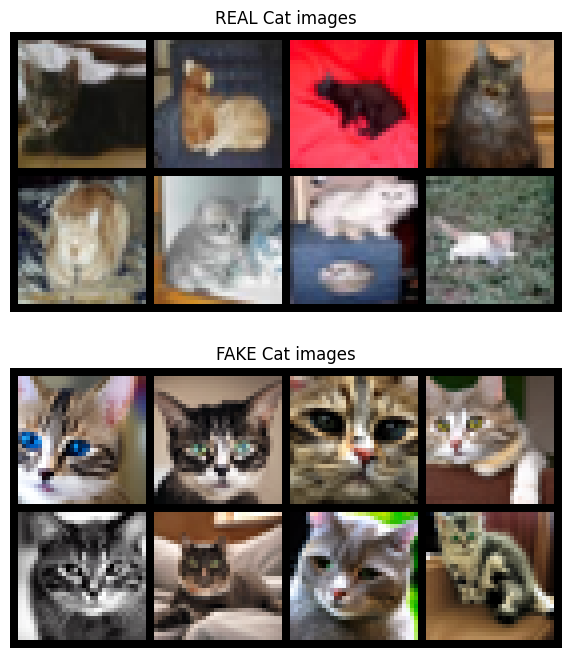

In [ ]:
# Load dataset and visualize

from google.colab import drive
drive.mount('/content/drive')

X, y = torch.load('/content/drive/MyDrive/CS224-FunadamentalsOfMachineLearning/HW2-DeepFakeCatDetector/hw2_data.pt')

# X, y = torch.load('hw2_data.pt')

print('Data shapes before flattening:')
print('X:', X.shape)  # 2000, 3, 32, 32, 2000 images, channel, height width
print('y:', y.shape)  # 2000 binary labels 0 is real, 1 is fake

# Print examples from each class
grid = vutils.make_grid(X[y==0][:8], nrow=4, padding=2, normalize=True)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].axis('off')
axs[0].set_title('REAL Cat images')
axs[0].imshow(grid.numpy().transpose((1, 2, 0)))

grid = vutils.make_grid(X[y==1][:8], nrow=4, padding=2, normalize=True)
axs[1].axis('off')
axs[1].set_title('FAKE Cat images')
axs[1].imshow(grid.numpy().transpose((1, 2, 0)))


X = X.flatten(start_dim=1)  # From now on, we work with the flattened vector
print(f"X shape after flattening: {X.shape}\n")

In [ ]:
# TODO [3 points]:
# Use scikit-learn logistic regression (with default hyper-parameters)
# with 5-fold CV to get the train and validation accuracies
# for a simple linear classifier - a good baseline for our MLP
n_folds = 5
val_accs = []  # store validation accuracy for each fold
train_accs = []  # store training accuracy for each fold

# TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled

# Used this website as a reference - https://www.askpython.com/python/examples/k-fold-cross-validation

myKFold = KFold(n_splits = n_folds, shuffle = True, random_state = 0)
model = LogisticRegression(solver = 'liblinear')

# Dimensions of X = 2000*3072
# Dimensions of Y = 2000
for trainIndex, testIndex in myKFold.split(X):
    XTrain, XTest = X[trainIndex,:], X[testIndex,:]
    yTrain, yTest = y[trainIndex], y[testIndex]

    # TODO: Fit model on training data
    model.fit(XTrain, yTrain)
    yTrainPred = model.predict(XTrain)
    yTestPred = model.predict(XTest)

    # TODO: Compute and store accuracy on train data

    train_acc = accuracy_score(yTrainPred, yTrain)
    train_accs.append(train_acc)

    # TODO: Compute and store accuracy on validation data

    val_acc = accuracy_score(yTestPred, yTest)
    val_accs.append(val_acc)

train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
val_std, val_mean = torch.std_mean(torch.tensor(val_accs))

# Standard error is standard deviation / sqrt(n), it is more typical to report this
rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds

print('Train Accuracy of each fold - {}'.format(train_accs))
print('Test Accuracy of each fold - {}'.format(val_accs))

print(f'Train Accuracy and standard error:\t {train_mean:.3f} +/- {train_std / rootn:.3f}')
print(f'Validation Accuracy and standard error:\t {val_mean:.3f} +/- {val_std / rootn:.3f}')

Train Accuracy of each fold - [0.991875, 0.99375, 0.993125, 0.99, 0.99125]
Test Accuracy of each fold - [0.625, 0.5825, 0.6475, 0.6225, 0.63]
Train Accuracy and standard error:	 0.992 +/- 0.001
Validation Accuracy and standard error:	 0.622 +/- 0.011


## Define the model [3 points]

- As always, implement an __init__ function and a forward function
- Use Linear layers with ReLU activations for the hidden layers
- 2 layers of hidden units. First layer has 128 hidden units, second layer has 64 hidden units.
- Output represents *binary* logits (must have correct shape to do that!)

In [ ]:
class MyMLP(nn.Module):
    # TODO: Define a multilayer perceptron [3 points]. Criteria above
    # Referred my own HW1 extra credit part an took help from TA

    def __init__(self, inputDimension = 3072, numOfClass = 2):
        super(MyMLP, self).__init__()
        self.d = inputDimension
        self.fc1 = nn.Linear(self.d, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, numOfClass)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

## Train function [6 points]
Make a function to train your neural net, following week 4 example

In [ ]:
# TODO [3 points]: a function to train your model
# (this will called for each hyper-parameter and fold)
# Don't forget to set model.train() during training, then model.eval() after done
# It doesn't matter in this case, but is good practice to prevent future bugs.

# Referenced this website - https://neptune.ai/blog/pytorch-loss-functions

def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False):
    """Train model using data from train_loader over n_epochs,
    using a Pytorch "optimizer" object (SGD in this case)
    and "criterion" as the loss function (CrossEntropyLoss in this case).
    """

    for epoch in range(n_epochs):
        # TODO: Train loop
        print ("This is ", epoch + 1, "th epoch")
        # Train mode
        model.train()

        # Set the current loss and validation loss value to zero
        currentLoss = 0
        validationLoss = 0

        #Iterate over training data
        for i, data in enumerate(train_loader, 0):    # trainloader, 0 -> 0 signifies training from scratch for each epoch
            inputs, trueLabels = data

            # Zero the gradients from the last loss.backward() to start anew for each batch
            optimizer.zero_grad()

            # Get predictions for inputs
            predLabels = model(inputs)

            # Calculate the loss using the criterion
            loss = criterion(predLabels, trueLabels)

            # Use backpropogation to find the gradients
            loss.backward()

            optimizer.step()

            print("Batch Training Loss = ",loss.item())

        if verbose:
            # Optional: Validation loop
            # Print out train/val loss during development
            # User verbose=False to turn off output of this in the submitted PDF

            # Eval mode
            model.eval()

            # To find validation loss
            # Get prediction on validation set and then call loss function
            # But first torch.no_grad()
            with torch.no_grad():
                for data in val_loader:
                    inputs, trueLabels = data
                    predLabels = model(inputs)

                    # Calculate the loss using the criterion
                    loss = criterion(predLabels, trueLabels)
                    validationLoss += loss.item() / len(val_loader)
                    print('Validation Loss in this epoch is %.3f' %validationLoss)

Loop over hyper-parameters and do 5-fold cross-validation for each setting, saving the train and validation mean accuracy and standard error.

In [ ]:
# TODO [3 points]: Perform cross-validation to get train/val accuracy
# for all hyper-parameter settings in the list below.
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0., 0.01]
batch_size = 50
n_epochs = 100
n_folds = 5

results = []
for lr in learning_rates:
    for wd in weight_decays:
        val_accs = []  # store validation accuracy for each fold
        train_accs = []  # store training accuracy for each fold

        # TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled

        myKFold = KFold(n_splits = n_folds, shuffle = True, random_state = 0)

        # TODO: Split data into train and validation
        for trainIndex, valIndex in myKFold.split(X):

                # TODO: Create data loaders to pass to training loop
                XTrain, XVal = X[trainIndex], X[valIndex]
                yTrain, yVal = y[trainIndex], y[valIndex]


                trainLoader = DataLoader(TensorDataset(XTrain, yTrain), batch_size = batch_size,shuffle = True)
                valLoader = DataLoader(TensorDataset(XVal, yVal), batch_size = len(XVal))

                # TODO: Initialize model, criterion (Cross entropy loss), and optimizer (SGD with various hyperparameters)
                model = MyMLP()
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=wd)

                # Call your training function
                train(model, trainLoader, valLoader, n_epochs, optimizer, criterion, verbose=True)

                with torch.no_grad():
                    # TODO: Use the trained model to estimate train/val accuracy
                    # (Hint: our model outputs logits, argmax is good to get the class prediction corresponding to max logit)
                    yPredTrain = model(XTrain).argmax(dim = 1)
                    yPredVal = model(XVal).argmax(dim = 1)

                    train_acc = accuracy_score(yPredTrain, yTrain)
                    train_accs.append(train_acc)

                    val_acc = accuracy_score(yPredVal, yVal)
                    val_accs.append(val_acc)

        # For each hyper-parameter, I'm storing the parameter values and the mean and standard error of accuracy in a list in "results".
        train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
        val_std, val_mean = torch.std_mean(torch.tensor(val_accs))
        rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
        train_se, val_se = train_std / rootn, val_std / rootn
        # Storing learning rate, weight decay value, train mean accuracy, standard error, val mean accuracy, standard error
        results.append((lr, wd, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))


Streaming output truncated to the last 5000 lines.
Batch Training Loss =  0.009962117299437523
Validation Loss in this epoch is 0.610
This is  54 th epoch
Batch Training Loss =  0.014653343707323074
Batch Training Loss =  0.021667368710041046
Batch Training Loss =  0.01874551922082901
Batch Training Loss =  0.010121243074536324
Batch Training Loss =  0.009626262821257114
Batch Training Loss =  0.01956731267273426
Batch Training Loss =  0.011670887470245361
Batch Training Loss =  0.013614343479275703
Batch Training Loss =  0.008769767358899117
Batch Training Loss =  0.011160261929035187
Batch Training Loss =  0.019418034702539444
Batch Training Loss =  0.025508452206850052
Batch Training Loss =  0.03344376012682915
Batch Training Loss =  0.039954256266355515
Batch Training Loss =  0.014760162681341171
Batch Training Loss =  0.011721516959369183
Batch Training Loss =  0.010644908994436264
Batch Training Loss =  0.014633812010288239
Batch Training Loss =  0.014834785833954811
Batch Traini

## Show result [3 points]

In [ ]:
# TODO [3 points]. Print the final result (should be no need to modify code)
# You should be able to see a best train acc > 95% , and a best val acc > 80%

# Create a DataFrame from the list of tuples, with labeled columns
column_names = ['learning_rate', 'weight_decay', 'train_mean', 'train_se','val_mean', 'val_se']
df = pd.DataFrame(results, columns=column_names)

# Make pretty printable strings, with standard error bars
df['train_output'] = df.apply(lambda row: f"{row['train_mean']:.3f} +/- {row['train_se']:.3f}", axis=1)
df['val_output'] = df.apply(lambda row: f"{row['val_mean']:.3f} +/- {row['val_se']:.3f}", axis=1)

print('Training results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='train_output')
display(pivot_df)

print('Validation results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='val_output')
display(pivot_df)

Training results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.811 +/- 0.006,1.000 +/- 0.000,1.000 +/- 0.000
0.01,0.814 +/- 0.004,0.999 +/- 0.000,0.998 +/- 0.001


Validation results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.768 +/- 0.008,0.818 +/- 0.006,0.825 +/- 0.008
0.01,0.771 +/- 0.010,0.809 +/- 0.009,0.824 +/- 0.004


## Extra credit

There are some nice opportunities for extra credit, though I will be fairly stingy with the points, so you should only try it if you're interested in learning more.
Some examples of things you could try for 1 extra point.
- Use t-SNE or UMAP to visualize a 2-d embedding of all the points, and see if the real and fake images are separable in the 2-d space.
- Use a more complex vision backbone like a pretrained ResNet to first embed the images, then train your MLP. You'll have to be careful to transform the images before input into a ResNet, as they usually expect a specific resolution. You can use torchvision transforms library for this. Does this increase accuracy? I don't know, but I speculate it won't help much - these embeddings are trained for classification accuracy, so they have no reason to preserve differences that are useful for finding fakes.
- Train a more complex vision backbone, instead of using the MLP. Again, a ResNet or a small vision transformer would be interesting. I think this would be the most typical and effective approach.
- Being an expert at hyper-parameter tuning is a skill that will benefit you greatly. Try a more fancy way to do this, like https://docs.wandb.ai, and see how well you can do on this assigment if you also vary other hyper-parameters (architecture, n_epochs, maybe early stopping, more learning rate/weight decay settings, regularizers, etc.)

Of course you can train your deepfake detector on my fakes, but how well will it do on ones from some other system? This is the fundamental research question in that field - how to build robust detectors that will work well even on new image generators.

## Extra Credit 1 - Visualizing using t-SNE



Data shapes before flattening:
X: torch.Size([2000, 3, 32, 32])
y: torch.Size([2000])
X shape after flattening: torch.Size([2000, 3072])



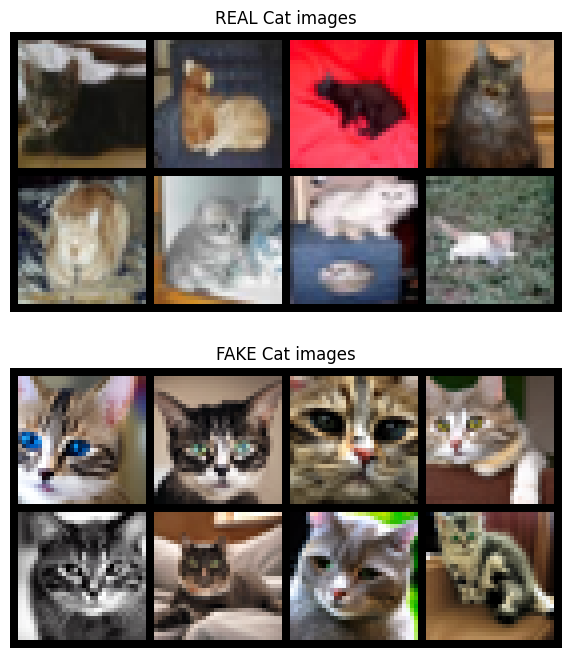

In [ ]:
# Reload the dataset as variable names may have been utilized elsewhere
# Referenced this website - https://builtin.com/data-science/tsne-python

X, y = torch.load('/content/drive/MyDrive/CS224-FunadamentalsOfMachineLearning/HW2-DeepFakeCatDetector/hw2_data.pt')

print('Data shapes before flattening:')
print('X:', X.shape)  # 2000, 3, 32, 32, 2000 images, channel, height width
print('y:', y.shape)  # 2000 binary labels 0 is real, 1 is fake

# Let's print some examples from each class
grid = vutils.make_grid(X[y==0][:8], nrow=4, padding=2, normalize=True)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].axis('off')
axs[0].set_title('REAL Cat images')
axs[0].imshow(grid.numpy().transpose((1, 2, 0)))

grid = vutils.make_grid(X[y==1][:8], nrow=4, padding=2, normalize=True)
axs[1].axis('off')
axs[1].set_title('FAKE Cat images')
axs[1].imshow(grid.numpy().transpose((1, 2, 0)))

X = X.flatten(start_dim=1)  # From now on, we work with the flattened vector
print(f"X shape after flattening: {X.shape}\n")

In [ ]:
# Convert data into a pandas dataframe

feat_cols = [ 'pixel' + str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X, columns = feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))

print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (2000, 3074)


In [ ]:
df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071,y,label,tsne-2d-first,tsne-2d-second
0,-0.019608,-0.137255,-0.200000,-0.168627,-0.168627,0.105882,0.372549,0.372549,0.160784,-0.168627,...,-0.411765,-0.380392,-0.364706,-0.356863,-0.341176,-0.325490,0,0,-3.737267,3.158624
1,-0.137255,0.113726,0.184314,0.043137,-0.349020,-0.568627,-0.623529,-0.600000,-0.600000,-0.592157,...,-0.380392,-0.443137,-0.474510,-0.529412,-0.529412,-0.513726,0,0,-1.125408,4.464776
2,0.976471,0.952941,0.960784,0.968627,0.968627,0.952941,0.874510,0.945098,0.968627,0.968627,...,-0.239216,-0.082353,-0.050980,-0.113725,-0.145098,-0.309804,0,0,-2.944373,2.424734
3,0.027451,-0.027451,-0.090196,-0.027451,0.113726,0.247059,0.341177,0.364706,0.411765,0.443137,...,-0.960784,-0.866667,-0.631373,-0.458824,-0.427451,-0.427451,0,0,-3.125390,2.433873
4,-0.945098,-0.945098,-0.960784,-0.945098,-0.913725,-0.913725,-0.866667,-0.803922,-0.858824,-0.929412,...,-0.239216,-0.356863,-0.356863,-0.403922,-0.364706,-0.066667,0,0,0.494876,3.700543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.866667,0.498039,-0.403922,-0.443137,-0.796078,-0.843137,-0.843137,-0.827451,-0.796078,-0.654902,...,0.388235,0.223529,-0.074510,-0.129412,0.121569,0.247059,1,1,-4.299292,-1.552993
1996,-0.176471,0.105882,0.498039,0.184314,0.058824,0.223529,0.058824,-0.356863,-0.482353,-0.247059,...,0.937255,-0.192157,-0.686275,-0.749020,-0.858824,-0.764706,1,1,1.290282,0.892527
1997,-0.733333,-0.670588,-0.647059,-0.662745,-0.654902,-0.482353,-0.458824,-0.639216,-0.686275,-0.725490,...,-0.450980,-0.521569,-0.560784,-0.482353,-0.537255,-0.482353,1,1,-4.479886,0.206603
1998,0.247059,0.254902,0.317647,0.239216,0.105882,0.403922,0.458824,0.403922,0.364706,0.396078,...,0.529412,0.435294,0.152941,-0.066667,-0.113725,-0.090196,1,1,2.020858,-1.507088


In [ ]:
# Since we have only 2000 datapoints we can try to use them all for the T-Distributed Stochastic Neighbour Embedding (t-SNE)
# Each sample has 3074 dimensions (RGB - 3, each one has 32 * 32 pixels)
from sklearn.manifold import TSNE
import time

time_start = time.time()

# n_components = 2 as we want only 2 features for a 2-d plot.
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(df[feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.805s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 7.352482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.339935
[t-SNE] KL divergence after 300 iterations: 2.498494
t-SNE done! Time elapsed: 8.877891302108765 seconds


In [ ]:
tsne_results.shape

(2000, 2)

<Axes: xlabel='tsne-2d-first', ylabel='tsne-2d-second'>

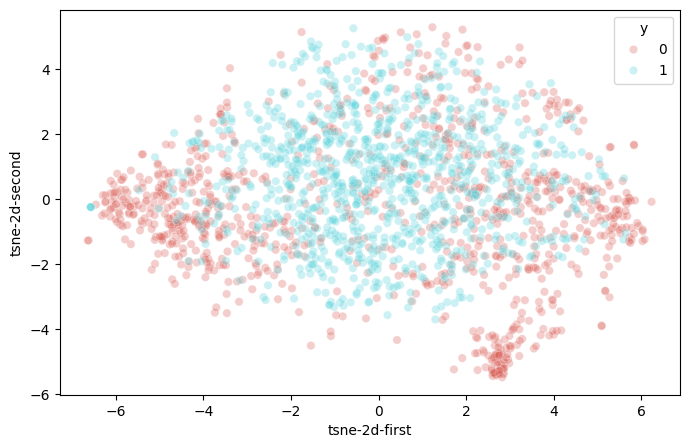

In [ ]:
# We have now reduced 3072 dimensional data to a 2-d embedding for all 2000 images
# Scatter plot with color for real and fake images

# Use seaborn for scatterplot
import seaborn

# Add tsne resulting dimensions to the dataframe as new columns
df['tsne-2d-first'] = tsne_results[:,0]
df['tsne-2d-second'] = tsne_results[:,1]

# Create a seaborn plot
plt.figure(figsize = (8,5))
seaborn.scatterplot(
    x = "tsne-2d-first", y = "tsne-2d-second",
    hue = "y",
    palette = seaborn.color_palette("hls", 2), # two colors for 2 classes - real and fake
    data = df,
    legend = "full",
    alpha = 0.3
)

***t-SNE Observation***

As we can see from the above plot, y = 0 class which are the real cat images are kind of concentrated to the left and right points and spread out like triangles toward the center. And as we move towards the center the density decreases.

And y = 1 class, which are the fake images are mostly in the center. Though there are some towards the corners too, but with a much lower density.

## Extra Credit 2 - Using ResNet (18) to embed images and then train using my MLP

In [ ]:
# I am using ResNet 18
# Referred https://pytorch.org/hub/pytorch_vision_resnet/ and
# https://pytorch.org/vision/stable/transforms.html

resNetModel = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Use eval mode as we are not using the resNetModel for training
resNetModel.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W),
# where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using
# mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

from torchvision.transforms import v2

from google.colab import drive
drive.mount('/content/drive')

# Load dataset
X, y = torch.load('/content/drive/MyDrive/CS224-FunadamentalsOfMachineLearning/HW2-DeepFakeCatDetector/hw2_data.pt')

def transformImgTensorForResnet(inputImageTensor):
    transforms = v2.Compose([
        v2.CenterCrop(size = 224),    # pad with zeroes around the center as image was 32 x 32 and now it is 224 x 224
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transforms(inputImageTensor)

print ("Shape of X before transformation was ", X.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of X before transformation was  torch.Size([2000, 3, 32, 32])


In [ ]:
# Transform the images as required by resnet

X = transformImgTensorForResnet(X)
print ("Shape of X after transformation is ", X.shape)

# RAM exceeding for embeddding, so trying to use GPU
if torch.cuda.is_available():
    X = X.to('cuda')
    resNetModel.to('cuda')

Shape of X after transformation is  torch.Size([2000, 3, 224, 224])


In [ ]:
# A function to generate embeddings using a given model

def genEmbeddings(input_batch, model = resNetModel):
    with torch.no_grad():
        output = model(input_batch)
    # print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    # probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # # print(probabilities)
    # print(probabilities.shape)
    return output

In [ ]:
# Generate the embeddings using ResNet 18
X = genEmbeddings(X, resNetModel)

In [ ]:
X.shape

torch.Size([2000, 1000])

In [ ]:
# Transfer embeddings back to CPU
X = X.detach().cpu()

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0., 0.01]
batch_size = 50
n_epochs = 100
n_folds = 5

results = []
for lr in learning_rates:
    for wd in weight_decays:
        val_accs = []  # store validation accuracy for each fold
        train_accs = []  # store training accuracy for each fold

        # TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled

        myKFold = KFold(n_splits = n_folds, shuffle = True, random_state = 0)

        # TODO: Split data into train and validation
        for trainIndex, valIndex in myKFold.split(X):

                # TODO: Create data loaders to pass to training loop
                XTrain, XVal = X[trainIndex], X[valIndex]
                yTrain, yVal = y[trainIndex], y[valIndex]


                trainLoader = DataLoader(TensorDataset(XTrain, yTrain), batch_size = batch_size,shuffle = True)
                valLoader = DataLoader(TensorDataset(XVal, yVal), batch_size = len(XVal))

                # TODO: Initialize model, criterion (Cross entropy loss), and optimizer (SGD with various hyperparameters)
                model = MyMLP(1000, 2)
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=wd)

                # Call your training function
                train(model, trainLoader, valLoader, n_epochs, optimizer, criterion, verbose=True)

                with torch.no_grad():
                    # TODO: Use the trained model to estimate train/val accuracy
                    # (Hint: our model outputs logits, argmax is good to get the class prediction corresponding to max logit)
                    yPredTrain = model(XTrain).argmax(dim = 1)
                    yPredVal = model(XVal).argmax(dim = 1)

                    train_acc = accuracy_score(yPredTrain, yTrain)
                    train_accs.append(train_acc)

                    val_acc = accuracy_score(yPredVal, yVal)
                    val_accs.append(val_acc)

        # For each hyper-parameter, I'm storing the parameter values and the mean and standard error of accuracy in a list in "results".
        train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
        val_std, val_mean = torch.std_mean(torch.tensor(val_accs))
        rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
        train_se, val_se = train_std / rootn, val_std / rootn
        # Storing learning rate, weight decay value, train mean accuracy, standard error, val mean accuracy, standard error
        results.append((lr, wd, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))

Streaming output truncated to the last 5000 lines.
Batch Training Loss =  0.6746610999107361
Validation Loss in this epoch is 0.634
This is  54 th epoch
Batch Training Loss =  0.6403040289878845
Batch Training Loss =  0.42420709133148193
Batch Training Loss =  0.7560130953788757
Batch Training Loss =  0.7024860978126526
Batch Training Loss =  0.652995228767395
Batch Training Loss =  0.3724589943885803
Batch Training Loss =  0.36517617106437683
Batch Training Loss =  0.3979174494743347
Batch Training Loss =  0.5190121531486511
Batch Training Loss =  0.5483348965644836
Batch Training Loss =  0.4080445468425751
Batch Training Loss =  0.432442843914032
Batch Training Loss =  0.43919411301612854
Batch Training Loss =  0.37716931104660034
Batch Training Loss =  0.4033195376396179
Batch Training Loss =  0.3891856372356415
Batch Training Loss =  0.42453107237815857
Batch Training Loss =  0.540072500705719
Batch Training Loss =  0.5575858354568481
Batch Training Loss =  0.3147521913051605
Batch

In [ ]:
# TODO [3 points]. Print the final result (should be no need to modify code)
# You should be able to see a best train acc > 95% , and a best val acc > 80%

# Create a DataFrame from the list of tuples, with labeled columns
column_names = ['learning_rate', 'weight_decay', 'train_mean', 'train_se','val_mean', 'val_se']
df = pd.DataFrame(results, columns=column_names)

# Make pretty printable strings, with standard error bars
df['train_output'] = df.apply(lambda row: f"{row['train_mean']:.3f} +/- {row['train_se']:.3f}", axis=1)
df['val_output'] = df.apply(lambda row: f"{row['val_mean']:.3f} +/- {row['val_se']:.3f}", axis=1)

print('Training results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='train_output')
display(pivot_df)

print('Validation results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='val_output')
display(pivot_df)

Training results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.869 +/- 0.004,0.917 +/- 0.017,0.871 +/- 0.007
0.01,0.871 +/- 0.002,0.924 +/- 0.014,0.719 +/- 0.045


Validation results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.855 +/- 0.004,0.875 +/- 0.015,0.854 +/- 0.009
0.01,0.856 +/- 0.007,0.886 +/- 0.008,0.719 +/- 0.043


***Using ResNet18 embeddings for MLP***

As can be seen above, although training accuracies are lower than earlier, but the validation accuracies have improved. And the range of improvement is between 7% - 9% which is actually pretty good.

## Extra Credit 3 - Train using ResNet instead of MLP

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Wed Jul 10 22:51:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              33W /  70W |  14399MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
resNetModel = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained = True)

X, y = torch.load('/content/drive/MyDrive/CS224-FunadamentalsOfMachineLearning/HW2-DeepFakeCatDetector/hw2_data.pt')
print ("Shape of X before transformation was ", X.shape)
X = transformImgTensorForResnet(X)
X = X[1000:,]
print ("Shape of X after transformation is ", X.shape)

if torch.cuda.is_available():
    X = X.to('cuda')
    resNetModel.to('cuda')
    y = y.to('cuda')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Shape of X before transformation was  torch.Size([2000, 3, 32, 32])
Shape of X after transformation is  torch.Size([1000, 3, 224, 224])


In [ ]:
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0., 0.01]
batch_size = 50
n_epochs = 10
n_folds = 5

results = []
for lr in learning_rates:
    for wd in weight_decays:
        val_accs = []  # store validation accuracy for each fold
        train_accs = []  # store training accuracy for each fold

        # TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled

        myKFold = KFold(n_splits = n_folds, shuffle = True, random_state = 0)

        # TODO: Split data into train and validation
        for trainIndex, valIndex in myKFold.split(X):

                # TODO: Create data loaders to pass to training loop
                XTrain, XVal = X[trainIndex], X[valIndex]
                yTrain, yVal = y[trainIndex], y[valIndex]


                trainLoader = DataLoader(TensorDataset(XTrain, yTrain), batch_size = batch_size,shuffle = True)
                valLoader = DataLoader(TensorDataset(XVal, yVal), batch_size = len(XVal))

                # TODO: Initialize model, criterion (Cross entropy loss), and optimizer (SGD with various hyperparameters)
                model = resNetModel
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=wd)

                # Call your training function
                train(model, trainLoader, valLoader, n_epochs, optimizer, criterion, verbose=True)

                with torch.no_grad():
                    # TODO: Use the trained model to estimate train/val accuracy
                    # (Hint: our model outputs logits, argmax is good to get the class prediction corresponding to max logit)
                    yPredTrain = model(XTrain).argmax(dim = 1)
                    yPredVal = model(XVal).argmax(dim = 1)

                    yPredTrain = yPredTrain.to('cpu')
                    yTrain = yTrain.to('cpu')
                    yPredVal = yPredVal.to('cpu')
                    yVal = yVal.to('cpu')

                    train_acc = accuracy_score(yPredTrain, yTrain)
                    train_accs.append(train_acc)

                    val_acc = accuracy_score(yPredVal, yVal)
                    val_accs.append(val_acc)

        # For each hyper-parameter, I'm storing the parameter values and the mean and standard error of accuracy in a list in "results".
        train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
        val_std, val_mean = torch.std_mean(torch.tensor(val_accs))
        rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
        train_se, val_se = train_std / rootn, val_std / rootn
        # Storing learning rate, weight decay value, train mean accuracy, standard error, val mean accuracy, standard error
        results.append((lr, wd, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))

Streaming output truncated to the last 5000 lines.
Batch Training Loss =  0.004150249529629946
Batch Training Loss =  0.0038616019301116467
Batch Training Loss =  0.004534918814897537
Batch Training Loss =  0.003911461681127548
Batch Training Loss =  0.004111708607524633
Batch Training Loss =  0.004181941505521536
Batch Training Loss =  0.003981165122240782
Batch Training Loss =  0.00420107739046216
Batch Training Loss =  0.003931490238755941
Batch Training Loss =  0.004143808968365192
Batch Training Loss =  0.0035789282992482185
Batch Training Loss =  0.003943626303225756
Batch Training Loss =  0.0036112547386437654
Validation Loss in this epoch is 0.004
This is  4 th epoch
Batch Training Loss =  0.004152604844421148
Batch Training Loss =  0.003898163791745901
Batch Training Loss =  0.004022727720439434
Batch Training Loss =  0.0037328845355659723
Batch Training Loss =  0.0039606173522770405
Batch Training Loss =  0.003829400287941098
Batch Training Loss =  0.00378497876226902
Batch T

In [ ]:
# TODO [3 points]. Print the final result (should be no need to modify code)
# You should be able to see a best train acc > 95% , and a best val acc > 80%

# Create a DataFrame from the list of tuples, with labeled columns
column_names = ['learning_rate', 'weight_decay', 'train_mean', 'train_se','val_mean', 'val_se']
df = pd.DataFrame(results, columns=column_names)

# Make pretty printable strings, with standard error bars
df['train_output'] = df.apply(lambda row: f"{row['train_mean']:.3f} +/- {row['train_se']:.3f}", axis=1)
df['val_output'] = df.apply(lambda row: f"{row['val_mean']:.3f} +/- {row['val_se']:.3f}", axis=1)

print('Training results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='train_output')
display(pivot_df)

print('Validation results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='val_output')
display(pivot_df)

Training results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000
0.01,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000


Validation results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000
0.01,1.000 +/- 0.000,1.000 +/- 0.000,1.000 +/- 0.000


## Extra Credit 4 - Tune with other hyper-parameters (architecture, n_epochs, maybe early stopping, more learning rate/weight decay settings, regularizers, etc.)

In [ ]:
# Changed model architecture
# Added more layers and increased the size of hidden layers

class MyMLP(nn.Module):
    def __init__(self, inputDimension = 3072, numOfClass = 2):
        super(MyMLP, self).__init__()
        self.d = inputDimension
        self.fc1 = nn.Linear(self.d, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, numOfClass)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        return self.fc7(x)

In [ ]:
X, y = torch.load('/content/drive/MyDrive/CS224-FunadamentalsOfMachineLearning/HW2-DeepFakeCatDetector/hw2_data.pt')
X = X.flatten(start_dim = 1)

In [ ]:
if torch.cuda.is_available():
    X = X.to('cuda')
    resNetModel.to('cuda')
    y = y.to('cuda')

In [ ]:
# TODO [3 points]: Perform cross-validation to get train/val accuracy
# for all hyper-parameter settings in the list below.

# Changed Learning Rates, Weight Decays and Batch Size as well
# Decreased num of epochs to 50

learning_rates = [0.25, 0.5, 1]
weight_decays = [0.1, 0.2]
batch_size = 100
n_epochs = 25
n_folds = 5

results = []
for lr in learning_rates:
    for wd in weight_decays:
        val_accs = []  # store validation accuracy for each fold
        train_accs = []  # store training accuracy for each fold

        # TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled

        myKFold = KFold(n_splits = n_folds, shuffle = True, random_state = 0)

        # TODO: Split data into train and validation
        for trainIndex, valIndex in myKFold.split(X):

                # TODO: Create data loaders to pass to training loop
                XTrain, XVal = X[trainIndex], X[valIndex]
                yTrain, yVal = y[trainIndex], y[valIndex]

                trainLoader = DataLoader(TensorDataset(XTrain, yTrain), batch_size = batch_size,shuffle = True)
                valLoader = DataLoader(TensorDataset(XVal, yVal), batch_size = len(XVal))

                # TODO: Initialize model, criterion (Cross entropy loss), and optimizer (SGD with various hyperparameters)
                model = MyMLP(3072, 2).to('cuda')
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=wd)

                # Call your training function
                train(model, trainLoader, valLoader, n_epochs, optimizer, criterion, verbose=True)

                with torch.no_grad():
                    # TODO: Use the trained model to estimate train/val accuracy
                    # (Hint: our model outputs logits, argmax is good to get the class prediction corresponding to max logit)
                    yPredTrain = model(XTrain).argmax(dim = 1)
                    yPredVal = model(XVal).argmax(dim = 1)

                    yPredTrain = yPredTrain.to('cpu')
                    yTrain = yTrain.to('cpu')
                    yPredVal = yPredVal.to('cpu')
                    yVal = yVal.to('cpu')

                    train_acc = accuracy_score(yPredTrain, yTrain)
                    train_accs.append(train_acc)

                    val_acc = accuracy_score(yPredVal, yVal)
                    val_accs.append(val_acc)

        # For each hyper-parameter, I'm storing the parameter values and the mean and standard error of accuracy in a list in "results".
        train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
        val_std, val_mean = torch.std_mean(torch.tensor(val_accs))
        rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
        train_se, val_se = train_std / rootn, val_std / rootn
        # Storing learning rate, weight decay value, train mean accuracy, standard error, val mean accuracy, standard error
        results.append((lr, wd, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))


Streaming output truncated to the last 5000 lines.
Batch Training Loss =  0.694323718547821
Batch Training Loss =  0.6929236650466919
Batch Training Loss =  0.6940005421638489
Batch Training Loss =  0.6929278373718262
Batch Training Loss =  0.6939830183982849
Batch Training Loss =  0.6929687261581421
Batch Training Loss =  0.6907215118408203
Batch Training Loss =  0.6941365003585815
Batch Training Loss =  0.6941438317298889
Batch Training Loss =  0.6932423114776611
Batch Training Loss =  0.6930080652236938
Batch Training Loss =  0.6919061541557312
Batch Training Loss =  0.6938329339027405
Validation Loss in this epoch is 0.695
This is  24 th epoch
Batch Training Loss =  0.6924738883972168
Batch Training Loss =  0.6975808143615723
Batch Training Loss =  0.6920196413993835
Batch Training Loss =  0.6936019062995911
Batch Training Loss =  0.6929470896720886
Batch Training Loss =  0.6979186534881592
Batch Training Loss =  0.6881599426269531
Batch Training Loss =  0.699129045009613
Batch Tra

In [ ]:
# TODO [3 points]. Print the final result (should be no need to modify code)
# You should be able to see a best train acc > 95% , and a best val acc > 80%

# Create a DataFrame from the list of tuples, with labeled columns
column_names = ['learning_rate', 'weight_decay', 'train_mean', 'train_se','val_mean', 'val_se']
df = pd.DataFrame(results, columns=column_names)

# Make pretty printable strings, with standard error bars
df['train_output'] = df.apply(lambda row: f"{row['train_mean']:.3f} +/- {row['train_se']:.3f}", axis=1)
df['val_output'] = df.apply(lambda row: f"{row['val_mean']:.3f} +/- {row['val_se']:.3f}", axis=1)

print('Training results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='train_output')
display(pivot_df)

print('Validation results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='val_output')
display(pivot_df)

Training results


learning_rate,0.25,0.50,1.00
weight_decay,,,
0.1,0.506 +/- 0.002,0.500 +/- 0.003,0.504 +/- 0.003
0.2,0.506 +/- 0.002,0.498 +/- 0.003,0.500 +/- 0.003


Validation results


learning_rate,0.25,0.50,1.00
weight_decay,,,
0.1,0.477 +/- 0.007,0.500 +/- 0.014,0.483 +/- 0.011
0.2,0.477 +/- 0.007,0.506 +/- 0.013,0.500 +/- 0.014


***Hyperparameter Tuning***
In this part, I varied

1. The model architecture - Added more layers, Increased the size of each hidden layer

2. Increase the batch size from 50 to 100

3. Increased the Learning Rates and Weight Decays

4. Decreased num of epochs to 25

As can be seen above, this resulted in pretty bad accuracies. One reason could be the short amount of epochs being used and the other could be the extremely high learning rates which may have contributed to the optimizer not being able to converge.

Key Takeaways - Train for a lot more epochs and keep the learning rates reasonably small.



